In [1]:
%%html
<style>
body {
    font-family: Monaco, cursive, sans-serif;
}
</style>   

In [2]:
#Marat Sans

<h1>Introduction</h1>
<p>The financial industry has yet to seen a full adpotion of Machine Learning models because interpretability of statistical/machine learning models used for decison making is not only desired but also often a regulatory requirement. For example, FCRA(Fair Credit Reporting Act) requires lenders to provide up to 4 decline reasons (adverse action codes) when they decline consumer for credit. These reasons have to be generated from the true underlying models for credit decisions, and the model must be able to isolate specific attributes of a consumer that led to the model’s negative decision. These regulatory requirements rule out the use of many popular model interpretation tools such as LIME(Local Interpretable Model-Agnostic Explanations) due to the use of surrogate model not the true underlying model, and loss/Gini reduction attribution methods due to not being consistent across samples/models.</p> 
<p>This notebook discusses the newly introducted model interpretation tool - SHAP (SHapley Additive exPlanations) as inspired by Shapley values from cooperative game theory. Shapley values is potentiallythe the only interpretation tool that satisfy regulatory requirements. Four models are built using the HELOC data from the challenge: logistic regression without interaction terms, logistic regression with interaction terms, XGBoost model and a Neural Network. Interpretations are provided both locally(sample level) and globally(model/class level) for each of these models using SHAP. </p> 


<h1>From linear model to Shapley Value</h1>
<p>A (generalized) linear regression model is considerred as an interpretable model. The contributions by a model attribute(feature) can be simply calculated by mutiplying the feature value with the coefficient of that feature, and then minus the expected(averaged) contribution by that feature. To explain, here is an excerpt from the book *Interpretable Machine Learning* by Christoph Molnar.</p> 
<p>https://christophm.github.io/interpretable-ml-book/shapley.html</p> 



Here's how a linear model prediction looks like for one data instance:

$$\hat{f}(x_{i\cdot})=\hat{f}(x_{i1},\ldots,x_{ip})=\beta_0+\beta_{1}x_{i1}+\ldots+\beta_{p}x_{ip}$$

where $x_{i\cdot}$ is the instance for which we want to compute the feature effects. Each $x_{ij}$ is a feature value, with $j\in{1,\ldots,p}$. The $\beta_j$ are the weights corresponding to $x_{ij}$.
The feature effect $\phi_{ij}$ of $x_{ij}$ on the prediction $\hat{f}(x_{i\cdot})$ is:

$$\phi_{ij}(\hat{f})=\beta_{j}x_{ij}-E(\beta_{j}X_{j})=\beta_{j}x_{ij}-\beta_{j}E(X_{j})$$

where $E(\beta_jX_{j})$ is the mean effect estimate for feature $X_{j}$. The effect is the difference between the feature contribution to the equation minus the average contribution. 

TBD - For a complex model, such as Gradient Boosting Trees or Neural Network, where data relationships can't be simpliy represented by coefficients, Shapley Value from Cooperative Game Theory can be used to calculate $\phi_{ij}$

How? Estimation?

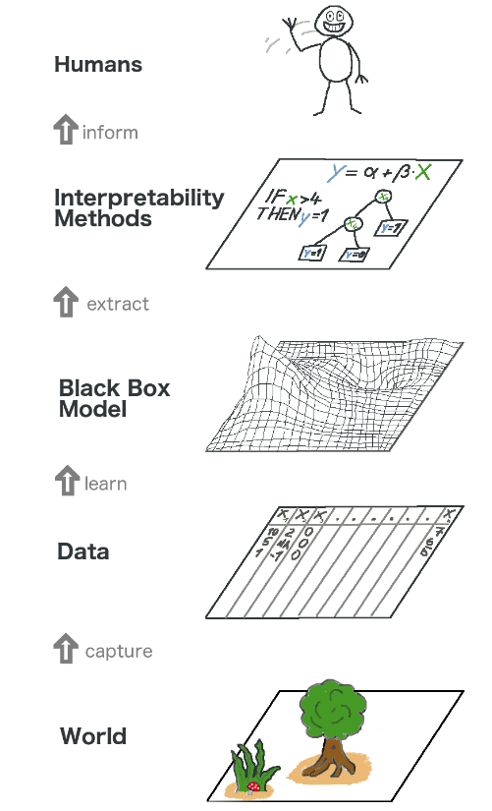

In [3]:
from IPython.display import Image
Image(filename = 'interpret_ML.png')


Youtube
Consistent: tree path tracing
Accurate: sum up to something
Model agnostic
Connection between local and global
Disadvantage: speed, but can be precalculate
A consistent and accurate way to attribute contributions of features (attributes) – Shapley Value
Link to shapley value

Local
Data processing
Shap
Shap processing to get reasons
Interactive
Two ways graphs(?)

Global
Feature Importance
Shap (vs. PDP)
Interactions

<h1>Importing packages and data Preprocessing</h1>

In [4]:
import pandas as pd
import numpy as np
import re
np.random.seed(21)
import xgboost as xgb
#import eli5
import matplotlib.pyplot as plt
import pickle
import shap
from ipywidgets import widgets, interactive, interactive_output, fixed, HBox, VBox, Label
from IPython.display import display, HTML
import seaborn as sns
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns

%matplotlib inline

/home/carsonyan/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
import fico_challenge_ultilities as hlp
import imp


In [6]:
#==========Data Processing================
dat = pd.read_csv('heloc_dataset_v1.csv')

#Target change to binary
dat['IsBad'] = dat['RiskPerformance']=='Bad'
dat.drop(columns='RiskPerformance', inplace=True)

feat_all = dat.columns
target = 'IsBad'
feat_cat = ['MaxDelq2PublicRecLast12M','MaxDelqEver']
feat_num = [e for e in feat_all if e not in feat_cat+[target]]

#Onehot coding for default values (-7,-8,-9) in numeric columns, replace default values with median 
dat, feat_num_med = hlp.oneHot(dat, feat_num)



In [7]:
#Split data into train, valid and test
dat['rand_num'] = np.random.permutation(np.arange(dat.shape[0]))
cut_1 = int(dat.shape[0]*0.6)
cut_2 = int(dat.shape[0]*0.8)
dat_train = dat.loc[dat['rand_num']<=cut_1,:]

dat_val = dat.loc[(dat['rand_num']>cut_1) & (dat['rand_num']<=cut_2) ,:]
dat_test = dat.loc[dat['rand_num']>cut_2,:]

In [8]:
#Force monotonicity of categorical features at the data input level by transforming them into target means
dat_train, cat_sum_final = hlp.getTargetMean(dat_train, feat_cat, target)


/home/carsonyan/Documents/FICO/fico_challenge_ultilities.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dat[f+'_c'] = dat[f].astype(str)
/home/carsonyan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
#Replace categorical fearures in dat_test and dat_val with the target mean summarized from dat_train
dat_val,_ = hlp.getTargetMean(dat_val, feat_cat, target, cat_sum_final=cat_sum_final)
dat_test,_ = hlp.getTargetMean(dat_test, feat_cat, target, cat_sum_final=cat_sum_final)

dat_train.drop(columns=['rand_num'], inplace=True) #feat_cat+
dat_train.to_pickle('dat_train.p')
dat_val.drop(columns=['rand_num'], inplace=True) #feat_cat+
dat_test.drop(columns=['rand_num'], inplace=True) #feat_cat+

In [10]:
dat_train_good = dat_train.loc[dat_train[target]==0,:]
dat_train_good_med = dat_train_good.median()

<h1>XGBoost</h1>

<h2>Train Model</h2>

In [11]:
#========Train model=============

f_names = [e for e in dat_train.columns if e!=target and e not in feat_cat and e not in [c+'_c' for c in feat_cat]]
pickle.dump(f_names, open('f_names','wb'))


train_DM5 = xgb.DMatrix(dat_train[f_names].values, dat_train[target].values, feature_names=f_names)
val_DM5 = xgb.DMatrix(dat_val[f_names].values, dat_val[target].values, feature_names=f_names)
test_DM5 = xgb.DMatrix(dat_test[f_names].values, dat_test[target].values, feature_names=f_names)

params = {
        'eta':0.05,
        'n_estimators':1000,
        'max_depth':4,
        'min_child_weight':10,
        'eval_metric':'auc',
        'sub_sample':0.8,
        'colsample_bytree':0.8,
        'objective':'binary:logistic',
        'seed':21
        }

#        'lambda':30,
#        'gamma':10

monotone_dict = {
 'ExternalRiskEstimate':-1,
 'MSinceOldestTradeOpen':-1,
 'MSinceMostRecentTradeOpen':-1,
 'AverageMInFile':-1,
 'NumSatisfactoryTrades':-1,
 'NumTrades60Ever2DerogPubRec':1,
 'NumTrades90Ever2DerogPubRec':1,
 'PercentTradesNeverDelq':-1,
 'MSinceMostRecentDelq':-1,
 'NumTotalTrades':0,
 'NumTradesOpeninLast12M':1,
 'PercentInstallTrades':0,
 'MSinceMostRecentInqexcl7days':-1,
 'NumInqLast6M':1,
 'NumInqLast6Mexcl7days':1,
 'NetFractionRevolvingBurden':1,
 'NetFractionInstallBurden':1,
 'NumRevolvingTradesWBalance':0,
 'NumInstallTradesWBalance':0,
 'NumBank2NatlTradesWHighUtilization':1,
 'PercentTradesWBalance':0,
 'ExternalRiskEstimate_9':0,
 'MSinceOldestTradeOpen_8':0,
 'MSinceOldestTradeOpen_9':0,
 'MSinceMostRecentTradeOpen_9':0,
 'AverageMInFile_9':0,
 'NumSatisfactoryTrades_9':0,
 'NumTrades60Ever2DerogPubRec_9':0,
 'NumTrades90Ever2DerogPubRec_9':0,
 'PercentTradesNeverDelq_9':0,
 'MSinceMostRecentDelq_7':0,
 'MSinceMostRecentDelq_8':0,
 'MSinceMostRecentDelq_9':0,
 'NumTotalTrades_9':0,
 'NumTradesOpeninLast12M_9':0,
 'PercentInstallTrades_9':0,
 'MSinceMostRecentInqexcl7days_7':0,
 'MSinceMostRecentInqexcl7days_8':0,
 'MSinceMostRecentInqexcl7days_9':0,
 'NumInqLast6M_9':0,
 'NumInqLast6Mexcl7days_9':0,
 'NetFractionRevolvingBurden_8':0,
 'NetFractionRevolvingBurden_9':0,
 'NetFractionInstallBurden_8':0,
 'NetFractionInstallBurden_9':0,
 'NumRevolvingTradesWBalance_8':0,
 'NumRevolvingTradesWBalance_9':0,
 'NumInstallTradesWBalance_8':0,
 'NumInstallTradesWBalance_9':0,
 'NumBank2NatlTradesWHighUtilization_8':0,
 'NumBank2NatlTradesWHighUtilization_9':0,
 'PercentTradesWBalance_8':0,
 'PercentTradesWBalance_9':0,
 'MaxDelq2PublicRecLast12M_tm':1,
 'MaxDelqEver_tm':1}


params['monotone_constraints'] = "("+",".join([str(e) for e in monotone_dict.values()])+")"

pickle.dump(params,open('params.p','wb'))

evalist = [(train_DM5,'train'),(val_DM5,'val')]
evals_result={}

import time
tick = time.time()
xgb0 = xgb.train(params, train_DM5, num_boost_round=params['n_estimators'], evals=evalist, evals_result=evals_result, verbose_eval=True, early_stopping_rounds=50)
tock = time.time()
print('Training took {0:.1f} minutes.'.format((tock-tick)/60))

xgb0.save_model('xgb0_fico.model')

[21:38:53] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-auc:0.770999	val-auc:0.775408
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 50 rounds.
[21:38:53] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-auc:0.77456	val-auc:0.779295
[21:38:53] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-auc:0.782104	val-auc:0.786489
[21:38:53] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-auc:0.782751	val-auc:0.787937
[21:38:53] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-auc:0.782423

[21:38:53] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[46]	train-auc:0.802007	val-auc:0.804178
[21:38:53] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[47]	train-auc:0.80242	val-auc:0.804699
[21:38:53] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[48]	train-auc:0.802774	val-auc:0.805131
[21:38:54] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[49]	train-auc:0.802966	val-auc:0.805323
[21:38:54] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[50]	train-auc:0.803343	val-auc:0.805426
[21:38:54] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned

[21:38:54] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[93]	train-auc:0.813609	val-auc:0.810365
[21:38:54] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[94]	train-auc:0.813734	val-auc:0.810349
[21:38:54] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[95]	train-auc:0.813907	val-auc:0.810254
[21:38:54] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[96]	train-auc:0.814194	val-auc:0.810508
[21:38:54] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[97]	train-auc:0.814421	val-auc:0.810565
[21:38:54] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 prune

[21:38:54] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[140]	train-auc:0.820346	val-auc:0.811862
[21:38:54] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[141]	train-auc:0.820475	val-auc:0.811813
[21:38:54] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[142]	train-auc:0.820518	val-auc:0.811887
[21:38:54] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[143]	train-auc:0.820739	val-auc:0.811912
[21:38:54] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[144]	train-auc:0.82083	val-auc:0.811952
[21:38:54] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 p

[186]	train-auc:0.826527	val-auc:0.811691
[21:38:55] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[187]	train-auc:0.826815	val-auc:0.811713
[21:38:55] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[188]	train-auc:0.82704	val-auc:0.811588
[21:38:55] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[189]	train-auc:0.827191	val-auc:0.811544
[21:38:55] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[190]	train-auc:0.827364	val-auc:0.81148
[21:38:55] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[191]	train-auc:0.827715	val-auc:0.811312
[21:38:55] /home/carsonyan/xgboost/src/tree/updater_prune.cc:74: tree 

<h3>Model Performance</h3> 
<p>The train, test and validation model performance measured in AUC are close. Because this competition focuses on interpretation rather than predictive power, no tunning is done for the model.</p>

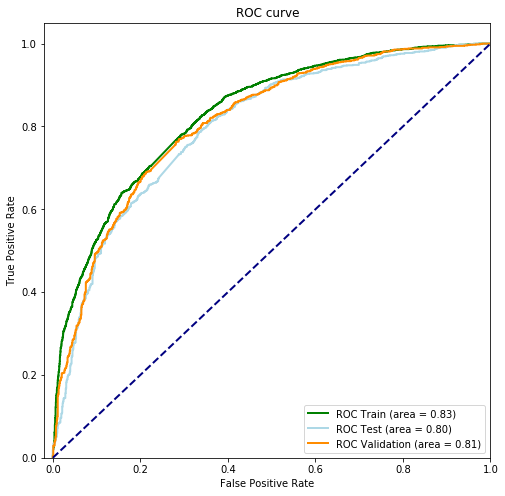

In [12]:
from sklearn.metrics import roc_curve, auc
# Compute micro-average ROC curve and ROC area
fpr_train, tpr_train, _ = roc_curve(dat_train[target], xgb0.predict(train_DM5))
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(dat_test[target], xgb0.predict(test_DM5))
roc_auc_test = auc(fpr_test, tpr_test)
fpr_val, tpr_val, _ = roc_curve(dat_val[target], xgb0.predict(val_DM5))
roc_auc_val = auc(fpr_val, tpr_val)
#xgb.plot_importance(gbm)
#plt.show()
plt.figure(figsize=(8,8))
plt.plot(fpr_train, tpr_train, color='green',
         lw=2, label='ROC Train (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='lightblue',
         lw=2, label='ROC Test (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_val, tpr_val, color='darkorange',
         lw=2, label='ROC Validation (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [14]:
def logistic(x):
    return 1/(1+np.exp(-x))

In [24]:
#Check accuracy
from sklearn.metrics import accuracy_score
print('Accuracy is {0:.3f} if label "bad" for predicted probability greater than 0.5'.format(accuracy_score(dat_train[target], xgb0.predict(train_DM5)>0.5)))

Accuracy is 0.743 if label "bad" for predicted probability greater than 0.5


<h2>Generate reject reasons by ranking Shapley values</h2> 

<p>Set the approval threshold to be the average odds. In reality, this threshold can be adjusted to reflect business strategy.</p>

In [25]:
shap_train = xgb0.predict(xgb.DMatrix(dat_train[f_names].values, feature_names=f_names), pred_contribs=True)
shap_train_bias = shap_train[0,-1]
approval_threshold = shap_train_bias.copy()

In [26]:
def logistic(x):
    return 1/(1+np.exp(-x))

In [27]:
#load data dictionary and create a AA reason table
meta = pd.read_excel('heloc_data_dictionary-2.xlsx')
eng = pd.read_excel('aa_english.xlsx')
meta_proc, eng_proc = hlp.processMeta(meta, eng, dat_train_good_med, cat_sum_final)

In [35]:
def getReasonsForSample(new_ins, f_names, feat_cat, feat_num, target, feat_num_med, cat_sum_final, meta_proc, eng_proc, approval_threshold=None, print_reasons=False):
     
    new_ins_p, new_ins_f = hlp.prepObs(new_ins, f_names, feat_cat, feat_num, target, feat_num_med, cat_sum_final)
    shap_pred, shap_bias, shap_pred_raw = hlp.generateRejectReasons(xgb0, f_names, new_ins_p, new_ins_f, meta_proc, eng_proc, print_reasons=print_reasons)
    
    
    if approval_threshold==None:
        approval_threshold=shap_bias 
        
    prediction = 'Bad' if np.sum(shap_pred_raw)>approval_threshold else 'Good'
    
    if np.sum(shap_pred_raw)<approval_threshold: #favorable observation:
        shap_pred = shap_pred.sort_values(by='shap', ascending=True).reset_index(drop=True)
    
    top4_reasons_df = shap_pred.loc[:3,['feature','val','Role']]
    top4_reasons =   shap_pred.loc[:3,'reason'].tolist()
    top4_explanations =   shap_pred.loc[:3,'explanation'].tolist()
    
    return {'reasons_list':[prediction]+top4_reasons+top4_explanations, 'reason_dataframe':top4_reasons_df,
            'shap':(shap_bias,shap_pred_raw)}
    
        

In [36]:
#Test case
new_ins = pd.read_csv('heloc_dataset_v1.csv').loc[0] #639
new_ins_p, new_ins_f = hlp.prepObs(new_ins, f_names, feat_cat, feat_num, target, feat_num_med, cat_sum_final)

getReasonsForSample(new_ins, f_names, feat_cat, feat_num, target, feat_num_med, cat_sum_final, meta_proc, eng_proc, approval_threshold=None, print_reasons=True)

----------Reasons Analysis--------
The predicted probability of going bad is 0.844
This probability is high.

ExternalRiskEstimate is too low
The Value Of The Consolidated Risk Markers Is Too Low

PercentTradesNeverDelq is too low
The Percentage Of Accounts That Were Never Delinquent Is Too Low

NumRevolvingTradesWBalance is 8.0
Not Desirable Number Of Revolving Accounts With Balance

MSinceMostRecentInqexcl7days is too low
Had A Credit Inquiry In Recent Months



{'reasons_list': ['Bad',
  'ExternalRiskEstimate is too low',
  'PercentTradesNeverDelq is too low',
  'NumRevolvingTradesWBalance is 8.0',
  'MSinceMostRecentInqexcl7days is too low',
  'The Value Of The Consolidated Risk Markers Is Too Low',
  'The Percentage Of Accounts That Were Never Delinquent Is Too Low',
  'Not Desirable Number Of Revolving Accounts With Balance',
  'Had A Credit Inquiry In Recent Months'],
 'reason_dataframe':                         feature   val       Role
 0          ExternalRiskEstimate  55.0  predictor
 1        PercentTradesNeverDelq  83.0  predictor
 2    NumRevolvingTradesWBalance   8.0  predictor
 3  MSinceMostRecentInqexcl7days   0.0  predictor,
 'shap': (0.06878038,
  array([[ 7.99081922e-01,  1.25445053e-01, -2.44102092e-03,
          -1.21863231e-01, -1.80104258e-03,  3.73612484e-03,
           0.00000000e+00,  3.05116832e-01,  1.17496066e-01,
          -2.91531812e-02, -1.35663049e-02,  6.65305406e-02,
           1.70642808e-01, -4.27611656e-02, 

<h3>Generate reasons for all samples</h3>
<p>Run the codes in the cell below to generate reasons why the prediction for each sample is made. </p>

In [26]:
# tic = time.time()
# samples =  pd.read_csv('heloc_dataset_v1.csv')
# samples['reasons_raw'] = samples.apply(lambda x: getReasonsForSample(x, f_names, feat_cat, feat_num, target, feat_num_med, cat_sum_final, meta_proc, eng_proc), axis=1)['reasons_list']
# samples[['Prediction', 'Reason1','Reason2','Reason3','Reason4','Explanation1','Explanation2','Explanation3','Explanation4']] = pd.DataFrame(samples['reasons_raw'].values.tolist(), index= samples.index)
# samples.drop(columns='reasons_raw', inplace=True)
# samples.to_csv('heloc_dataset_reasons.csv')
# toc = time.time()
# print('It took {0:.1f} minutes'.format((toc-tic)/60))

It took 17.9 minutes


<h2>Interactive Plot</h2>  

In [31]:
# load JS in order to use some of the plotting functions from the shap
# package in the notebook
shap.initjs()

# create our SHAP explainer
shap_explainer = shap.TreeExplainer(xgb0)
# calculate the shapley values for dat_train
shap_vals = shap_explainer.shap_values(dat_train[f_names]) #, ntree_limit=xgb0.best_iteration

#Check if the values generated are the same from XGBoost
print(np.all(np.isclose(shap_train[:,:-1],shap_vals)))


# plot the explanation for a single prediction
#shap.force_plot(shap_explainer.expected_value, shap_vals[0, :], dat_train.iloc[0, :])

True


In [25]:
deciles_n = 20
decl_res = []

for i in range(4):
    if top_4_reasons.loc[i,'feature']=='bias':
        break
    else:
        decl_this = dat_train[top_4_reasons.loc[i,'feature']].quantile([m/(deciles_n) for m in list(range(deciles_n+1))])
        decl_unique_this = np.append(decl_this.values, top_4_reasons.loc[i,'val'])
        decl_unique_this = np.unique(decl_unique_this)
        decl_unique_this = np.sort(decl_unique_this)
        decl_res.append(decl_unique_this)


In [26]:
def showGraph(n, w0, w1, w2, w3, approval_threshold=None, print_original_reasons=True):
    
    new_ins_sim = new_ins.copy()
    for i, w in zip(range(4), [w0, w1, w2, w3]):
        if top_4_reasons.loc[i,'feature'][-2:] in ['_7','_8','_9']: #if default value flag becomes important predictor:
            if w == 0: #if input is 0 - no default value
                if new_ins_sim[top_4_reasons.loc[i,'feature'][:-2]]<0: #check if original feature values is default value
                    #print(new_ins_sim[top_4_reasons.loc[i,'feature'][:-2]])
                    # if default, replace with median of dat
                    new_ins_sim[top_4_reasons.loc[i,'feature'][:-2]]=dat.loc[dat[top_4_reasons.loc[i,'feature'][:-2]]>=0, top_4_reasons.loc[i,'feature'][:-2]].median()
            else:
                new_ins_sim[top_4_reasons.loc[i,'feature'][:-2]]=new_ins[top_4_reasons.loc[i,'feature'][:-2]]
        elif new_ins_sim[top_4_reasons.loc[i,'feature']]>=0: #Not default value in predictor
                new_ins_sim[top_4_reasons.loc[i,'feature']] = w
        else:
            display(HTML('<p>{} has default value and will be replaced by the input value.</br>'.format(top_4_reasons.loc[i,'feature']))) 
            #val = -new_ins_sim[top_4_reasons.loc[i,'feature']]
            new_ins_sim[top_4_reasons.loc[i,'feature']] = w
            #new_ins_sim[top_4_reasons.loc[i,'feature']+'_'+str(val)] = 0
            
            
    #new_ins_sim[top_4_reasons.loc[0,'feature']] = w0
    #new_ins_sim[top_4_reasons.loc[1,'feature']] = w1
    #new_ins_sim[top_4_reasons.loc[2,'feature']] = w2
    #new_ins_sim[top_4_reasons.loc[3,'feature']] = w3
    
    #new_ins_p, new_ins_f = hlp.prepObs(new_ins, f_names, feat_cat, feat_num, target, feat_num_med, cat_sum_final)
    new_ins_sim_p, new_ins_sim_f = hlp.prepObs(new_ins_sim, f_names, feat_cat, feat_num, target, feat_num_med, cat_sum_final)
    #print(new_ins_sim['MaxDelq2PublicRecLast12M'])
    #print(new_ins_sim_f['MaxDelq2PublicRecLast12M_tm'])
    #shap_pred_sim, shap_pred_bias_sim, shap_pred_raw_sim = generateRejectReasons(new_ins_sim, new_ins_sim_f, print_reasons=print_original_reasons)
    #print(type(new_ins_sim))
    #print(type(new_ins_sim_p))
    #print(type(new_ins_sim_f))
    
    shap_pred_sim, shap_pred_bias_sim, shap_pred_raw_sim = hlp.generateRejectReasons(xgb0, f_names, new_ins_sim_p, new_ins_sim_f, meta_proc, eng_proc, print_reasons=print_original_reasons)
    
    #print(np.isclose(shap_pred_raw_sim,shap_pred_raw))
    #print(new_ins_sim)
    pred_sim =  logistic(np.sum(shap_pred_raw_sim)+shap_pred_bias_sim)
    if pred_sim >= logistic(approval_threshold):
        c, dc = 'red', 'rejected'
    else:
        c, dc = 'green', 'approved'
    display(HTML('<h3>New predicted probability is <font color="{0:s}">{1:.1f}%</font>, this application will be <font color="{0:s}">{2:s}</font> based on the approval threshold.</h3>'.format(c,pred_sim*100, dc))) # logistic(np.sum(shap_pred_raw_sim))))
    display(HTML('<p>{0:s} original value is {1:.1f}; New value is {2:.1f}</br>'.format(top_4_reasons.loc[0,'feature'], new_ins_f[top_4_reasons.loc[0,'feature']] if top_4_reasons.loc[0,'Role']!='predictor_cat' else new_ins_p[top_4_reasons.loc[0,'feature']].iloc[0],w0)))
    display(HTML('<p>{0:s} original value is {1:.1f}; New value is {2:.1f}</br>'.format(top_4_reasons.loc[1,'feature'], new_ins_f[top_4_reasons.loc[1,'feature']] if top_4_reasons.loc[1,'Role']!='predictor_cat' else new_ins_p[top_4_reasons.loc[1,'feature']].iloc[0],w1)))
    display(HTML('<p>{0:s} original value is {1:.1f}; New value is {2:.1f}</br>'.format(top_4_reasons.loc[2,'feature'], new_ins_f[top_4_reasons.loc[2,'feature']] if top_4_reasons.loc[2,'Role']!='predictor_cat' else new_ins_p[top_4_reasons.loc[2,'feature']].iloc[0],w2)))
    display(HTML('<p>{0:s} original value is {1:.1f}; New value is {2:.1f}</br>'.format(top_4_reasons.loc[3,'feature'], new_ins_f[top_4_reasons.loc[3,'feature']] if top_4_reasons.loc[3,'Role']!='predictor_cat' else new_ins_p[top_4_reasons.loc[3,'feature']].iloc[0],w3)))
    #display(HTML('<p>Original predicted probability is {0:.3f}; Current predicted probability is {1:.3f}</br>'.format(logistic(np.sum(shap_pred_raw)), logistic(np.sum(shap_pred_raw_sim)))))
    display(shap.force_plot(shap_explainer.expected_value, shap_pred_raw_sim, new_ins_sim[f_names], link="logit"))
    
    

In [27]:
#style = {'description_width': 'initial'}
n = widgets.IntText()


w0 = widgets.SelectionSlider(
    options=decl_res[0],
    value=top_4_reasons.loc[0,'val'],
    #description='',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    #style=style,
    readout=True)

w1 = widgets.SelectionSlider(
    options=decl_res[1],
    value=top_4_reasons.loc[1,'val'],
    #description='',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    #style=style,
    readout=True)

w2 = widgets.SelectionSlider(
    options=decl_res[2],
    value=top_4_reasons.loc[2,'val'],
    #description='',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    #style=style,
    readout=True)

w3 = widgets.SelectionSlider(
    options=decl_res[3],
    value=top_4_reasons.loc[3,'val'],
    #description='',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    #style=style,
    readout=True)


ui = widgets.VBox([HBox([Label(top_4_reasons.loc[0,'feature']),w0]), 
                   HBox([Label(top_4_reasons.loc[1,'feature']),w1]),
                   HBox([Label(top_4_reasons.loc[2,'feature']),w2]),
                   HBox([Label(top_4_reasons.loc[3,'feature']),w3])])


In [28]:
pred_orig =  logistic(np.sum(shap_pred_raw)+shap_bias)
if pred_orig >= logistic(approval_threshold):
    c, dc = 'red', 'rejected'
else:
    c, dc = 'green', 'approved'

display(HTML('<h3>Original predicted probability is <font color="{0:s}">{1:.1f}%</font>, this application will be <font color="{0:s}">{2:s}</font> based on the approval threshold.</h3>'.format(c, pred_orig*100, dc))) # logistic(np.sum(shap_pred_raw_sim))))
display(HTML('<p>Top reasons:</br>'))
for i in range(4):
#    if (shap_pred_sort.loc[i,'feature'] == 'bias') or (shap_pred_sort.loc[i,'shap'] <= 0):#This happens when predicted prob is low.
#        break
    display((HTML('<p>{}'.format(shap_pred_sort.loc[i,'reason']) + '; English: {}.</br>'.format(shap_pred_sort.loc[i,'explanation']))))      

display(shap.force_plot(shap_explainer.expected_value, shap_pred_raw, new_ins[f_names], link="logit"))
out = interactive_output(showGraph, {'w0': w0, 'w1': w1, 'w2': w2,'w3':w3, 'approval_threshold':fixed(approval_threshold), 'print_original_reasons':fixed(False)})
display(ui, out)

Output()

<h2>Cross-over Plot</h2> 

In [29]:
def decisionBoundaryPlot(top_4_reasons, x_feature, y_feature, decision, figsize=(8,6)):
    
    #Find index
    d0 = top_4_reasons.index[top_4_reasons['feature'] == x_feature][0]
    d1 = top_4_reasons.index[top_4_reasons['feature'] == y_feature][0]
    
    if d0 == d1:
        display('Please select two different fearures.')
    else:
        #Every combinations
        x = decl_res[d0]
        y = decl_res[d1]
        X, Y = np.meshgrid(x, y)

        #Original datapoint
        x_this = new_ins[top_4_reasons.loc[d0,'feature']]
        y_this = new_ins[top_4_reasons.loc[d1,'feature']]

        #Sythetic data
        new_ins_grid = pd.concat([new_ins]*((X.shape[0])*(X.shape[1])), axis=1).T.reset_index(drop=True)
        new_ins_grid[top_4_reasons.loc[d0,'feature']] = X.reshape((X.shape[0])*(X.shape[1]),-1)
        new_ins_grid[top_4_reasons.loc[d1,'feature']] = Y.reshape((Y.shape[0])*(Y.shape[1]),-1)
        new_ins_grid['IsBad'] = new_ins_grid['RiskPerformance']=='Bad'
        new_ins_grid.drop(columns='RiskPerformance', inplace=True)
        new_ins_grid, _ = hlp.oneHot(new_ins_grid, feat_num)
        new_ins_grid = new_ins_grid.apply(pd.to_numeric)
        new_ins_grid,_ = hlp.getTargetMean(new_ins_grid, feat_cat, target, cat_sum_final=cat_sum_final)
        for f in list(set(f_names)-set(new_ins_grid.columns)):
            new_ins_grid[f]=False

        #Predictions
        pred_grid = xgb0.predict(xgb.DMatrix(new_ins_grid[f_names].values, feature_names=f_names))
        Z = pred_grid.reshape(X.shape[0], X.shape[1])

        plt.figure(figsize=figsize)
        #ct_line = plt.contour(X, Y, Z, pred_grid.shape[0], colors=('k',))
        ct = plt.contourf(X,Y,Z, 20, cmap='RdYlGn_r') #pred_grid.shape[0], summer
        boundary_idx = np.argmax(ct.levels>logistic(approval_threshold))
        ct2 = plt.contour(ct, levels=[ct.levels[boundary_idx]], colors='#FF7F0D', linewidths=5)
        cbar = plt.colorbar(ct)
        #cbar.ax.set_ylabel('verbosity coefficient')
        # Add the contour line levels to the colorbar
        cbar.add_lines(ct2)
        plt.plot([x_this], [y_this], marker='X', markersize=8, color="yellow" if decision=='rejected' else "#0DFBFF")
        plt.xlabel(x_feature)
        plt.ylabel(y_feature)

In [30]:
top_4_reasons_list = top_4_reasons['feature'].tolist()

w_x =  widgets.Dropdown(
    options=top_4_reasons_list,
    value=top_4_reasons_list[0],
    description='Feature 1:',
    disabled=False)
    
w_y =  widgets.Dropdown(
    options=top_4_reasons_list,
    value=top_4_reasons_list[1],
    description='Feature 2:',
    disabled=False)


out_c = interactive(decisionBoundaryPlot, top_4_reasons=fixed(top_4_reasons), x_feature=w_x, y_feature=w_y, decision=fixed(dc), figsize=fixed((8,6)))
display(out_c)
    

interactive(children=(Dropdown(description='Feature 1:', options=('ExternalRiskEstimate', 'PercentTradesNeverD…

<h2>Global Interpretation</h2> 

<h3>Feature Importance</h3> 

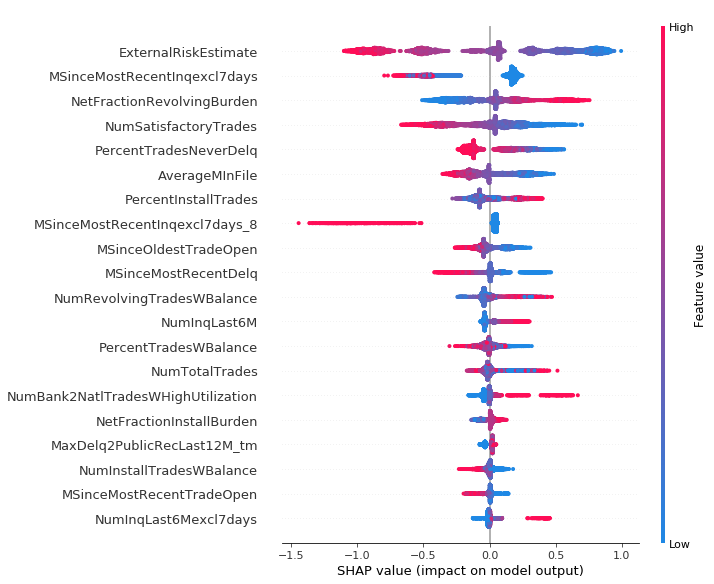

In [31]:
shap.summary_plot(shap_vals, dat_train[f_names])

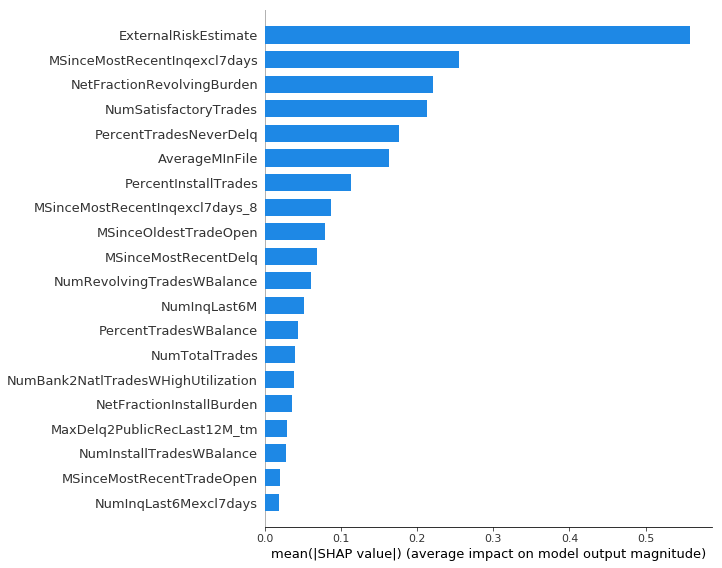

In [32]:
shap.summary_plot(shap_vals, dat_train[f_names], plot_type="bar")

<h3>Partial Dependence Plots</h3> 

In [33]:
w_main =  widgets.Dropdown(
    options=f_names,
    value='ExternalRiskEstimate',
    description='Main Feature:',
    disabled=False)
    
w_interact =  widgets.Dropdown(
    options=f_names+['auto'],
    value='auto',
    description='Interact Feature:',
    disabled=False)

In [34]:
def plot_dependence(main,interact,shap_vals,data):
    shap.dependence_plot(main, shap_vals, data, interaction_index = interact,alpha=0.7, show=False)
    plt.gcf().set_size_inches(10, 8)
    plt.show()

In [35]:
out_pd = interactive(plot_dependence, main=w_main,interact=w_interact,shap_vals=fixed(shap_vals),data=fixed(dat_train[f_names]))
display(out_pd)

interactive(children=(Dropdown(description='Main Feature:', options=('ExternalRiskEstimate', 'MSinceOldestTrad…

In [ ]:
#PDP

In [40]:
pred_train = xgb0.predict(train_DM5)
pred_label_train = pred_train>logistic(approval_threshold)

In [89]:
shap_vals_true = shap_vals[pred_label_train,:]
shap_vals_false = shap_vals[~pred_label_train,:]
dat_train_true = dat_train.loc[pred_label_train,f_names].values
dat_train_false = dat_train.loc[~pred_label_train,f_names].values


In [117]:
f_names

['ExternalRiskEstimate',
 'MSinceOldestTradeOpen',
 'MSinceMostRecentTradeOpen',
 'AverageMInFile',
 'NumSatisfactoryTrades',
 'NumTrades60Ever2DerogPubRec',
 'NumTrades90Ever2DerogPubRec',
 'PercentTradesNeverDelq',
 'MSinceMostRecentDelq',
 'NumTotalTrades',
 'NumTradesOpeninLast12M',
 'PercentInstallTrades',
 'MSinceMostRecentInqexcl7days',
 'NumInqLast6M',
 'NumInqLast6Mexcl7days',
 'NetFractionRevolvingBurden',
 'NetFractionInstallBurden',
 'NumRevolvingTradesWBalance',
 'NumInstallTradesWBalance',
 'NumBank2NatlTradesWHighUtilization',
 'PercentTradesWBalance',
 'ExternalRiskEstimate_9',
 'MSinceOldestTradeOpen_8',
 'MSinceOldestTradeOpen_9',
 'MSinceMostRecentTradeOpen_9',
 'AverageMInFile_9',
 'NumSatisfactoryTrades_9',
 'NumTrades60Ever2DerogPubRec_9',
 'NumTrades90Ever2DerogPubRec_9',
 'PercentTradesNeverDelq_9',
 'MSinceMostRecentDelq_7',
 'MSinceMostRecentDelq_8',
 'MSinceMostRecentDelq_9',
 'NumTotalTrades_9',
 'NumTradesOpeninLast12M_9',
 'PercentInstallTrades_9',
 'MSinceMostRecentInqexcl7days_7',
 'MSinceMostRecentInqexcl7days_8',
 'MSinceMostRecentInqexcl7days_9',
 'NumInqLast6M_9',
 'NumInqLast6Mexcl7days_9',
 'NetFractionRevolvingBurden_8',
 'NetFractionRevolvingBurden_9',
 'NetFractionInstallBurden_8',
 'NetFractionInstallBurden_9',
 'NumRevolvingTradesWBalance_8',
 'NumRevolvingTradesWBalance_9',
 'NumInstallTradesWBalance_8',
 'NumInstallTradesWBalance_9',
 'NumBank2NatlTradesWHighUtilization_8',
 'NumBank2NatlTradesWHighUtilization_9',
 'PercentTradesWBalance_8',
 'PercentTradesWBalance_9',
 'MaxDelq2PublicRecLast12M_tm',
 'MaxDelqEver_tm']

In [118]:
x = 'ExternalRiskEstimate'
idx_x = f_names.index(x)

/home/carsonyan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


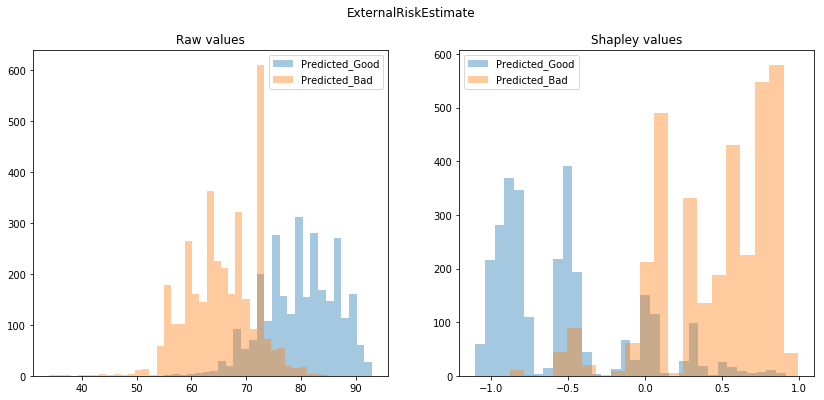

In [120]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1, 2, 1)
sns.distplot(dat_train_false[:,idx_x].astype(np.float),kde=False, ax=ax1, label='Predicted_Good')
sns.distplot(dat_train_true[:,idx_x].astype(np.float),kde=False, ax=ax1, label='Predicted_Bad')
ax1.set_title('Raw values')
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
sns.distplot(shap_vals_false[:,idx_x],kde=False, ax=ax2, label='Predicted_Good')
sns.distplot(shap_vals_true[:,idx_x],kde=False, ax=ax2, label='Predicted_Bad')
ax2.set_title('Shapley values')
ax2.legend()

#plt.gcf().set_size_inches(10, 8)
fig.suptitle(x)
plt.show()